In [1]:
from datasets import load_dataset

class HFDataset:
    def __init__(self, name='henrik-dra/energy-meter'):
        self.name = name
        try:
            self.dataset = load_dataset(self.name)
        except Exception as e:
            self.dataset = None

    def __repr__(self):
        if self.dataset:
            return repr(self.dataset)
        else:
            return f"Dataset {self.name} could not be loaded."
    
    def __getitem__(self, key):
        if self.dataset and key in self.dataset:
            return self.dataset[key]
        else:
            raise KeyError(f"'{key}' not found in the dataset.")


In [2]:
data = HFDataset()
print(data)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 138
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 30
    })
})


In [3]:
train_data, test_data = data['train'], data['test']

Label: 9845.9


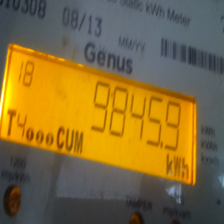

Label: 5371.6


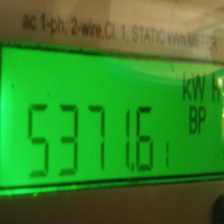

In [4]:
from IPython.display import display

num_imgs = 2

# Display a few images from the training set
for idx, data in enumerate(test_data):
    if idx == num_imgs:
        break
    img, target = data['image'], data['label']
    img_resized = img.resize((224, 224))
    print(f"Label: {target}")
    display(img_resized)

In [5]:
from transformers import AutoModelForCausalLM, AutoProcessor, AutoConfig
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = "ahmed-salim/meter-vision"
config = AutoConfig.from_pretrained(checkpoint_path, trust_remote_code=True)
config.vision_config.model_type = "davit"
model = AutoModelForCausalLM.from_pretrained(checkpoint_path, config=config, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(checkpoint_path, trust_remote_code=True)

torch.cuda.empty_cache()


<unknown>:499: SyntaxWarning: invalid escape sequence '\d'


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
from difflib import SequenceMatcher
from tqdm import tqdm
import re

In [7]:
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


def normalize_number(s):
    try:
        s_clean = re.sub(r"[^\d.]", "", s)
        return float(s_clean.lstrip("0") or "0")
    except:
        return None

def string_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [8]:
# Run inference
ground_truths_raw = []
predictions_raw = []
ground_truths_float = []
predictions_float = []
similarities = []


for example in tqdm(test_data):
    gt = str(example['label'])
    pred_dict = run_example("DocVQA", 'What is the meter values?', example['image'])
    pred = str(list(pred_dict.values())[0])

    ground_truths_raw.append(gt)
    predictions_raw.append(pred)
    similarities.append(string_similarity(gt, pred))

    gt_num = normalize_number(gt)
    pred_num = normalize_number(pred)

    ground_truths_float.append(gt_num)
    predictions_float.append(pred_num)


valid_indices = [
    i for i in range(len(ground_truths_float))
    if ground_truths_float[i] is not None and predictions_float[i] is not None
]

gt_numeric = np.array([ground_truths_float[i] for i in valid_indices])
pred_numeric = np.array([predictions_float[i] for i in valid_indices])

exact_match_acc = accuracy_score(ground_truths_raw, predictions_raw)
avg_string_sim = np.mean(similarities)
mae = mean_absolute_error(gt_numeric, pred_numeric)

print("\n=== Evaluation Metrics ===")
print(f"Exact Match Accuracy     : {exact_match_acc:.2%}")
print(f"Average String Similarity: {avg_string_sim:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print("==========================")

100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


=== Evaluation Metrics ===
Exact Match Accuracy     : 70.00%
Average String Similarity: 0.95
Mean Absolute Error (MAE): 3687.26


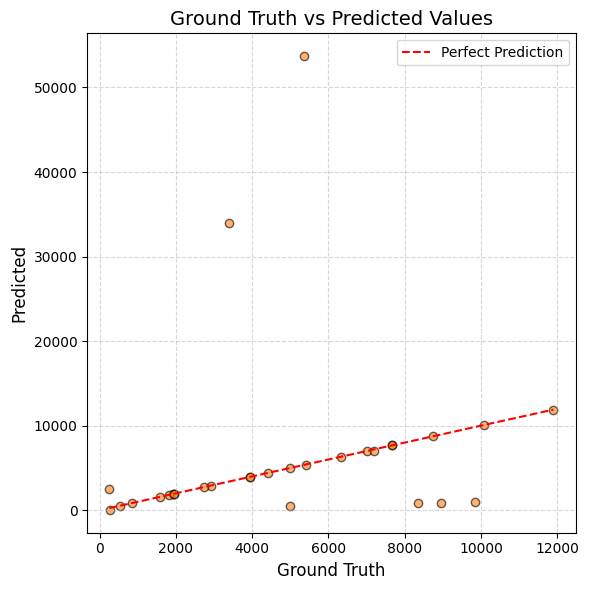

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(gt_numeric, pred_numeric, alpha=0.6, color='#ff7f0e', edgecolors='k')
plt.plot([gt_numeric.min(), gt_numeric.max()],
         [gt_numeric.min(), gt_numeric.max()], 'r--', label="Perfect Prediction")

plt.title("Ground Truth vs Predicted Values", fontsize=14)
plt.xlabel("Ground Truth", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../results/gt_vs_pred.png", bbox_inches='tight', dpi=300)
plt.show()


Example 1:
Model Answer : 924.9
Ground Truth : 9845.9
Match        : False



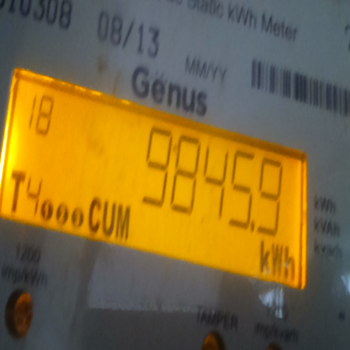

Example 2:
Model Answer : 53716.1
Ground Truth : 5371.6
Match        : False



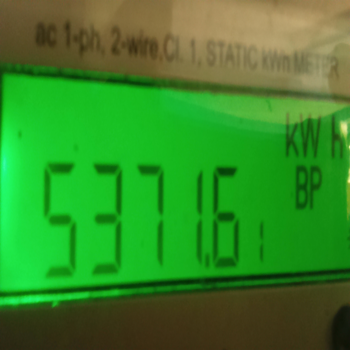

Example 3:
Model Answer : 007666.8
Ground Truth : 007666.8
Match        : True



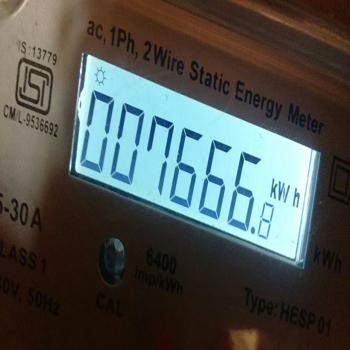

Example 4:
Model Answer : 3939.3
Ground Truth : 3939.3
Match        : True



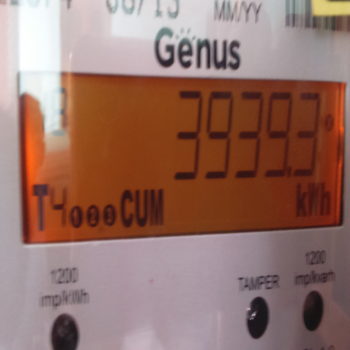

Example 5:
Model Answer : 498.13
Ground Truth : 4981.3
Match        : False



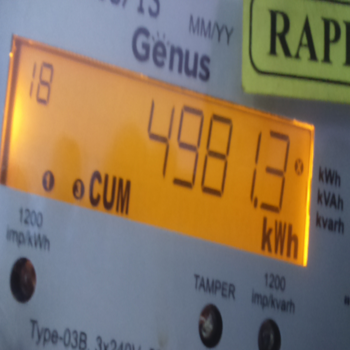

Example 6:
Model Answer : 00834.7
Ground Truth : 008347.9
Match        : False



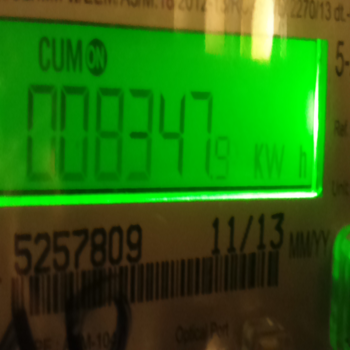

Example 7:
Model Answer : 10082.1
Ground Truth : 10082.1
Match        : True



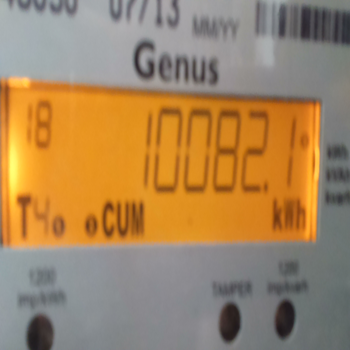

Example 8:
Model Answer : 895.23
Ground Truth : 8952.3
Match        : False



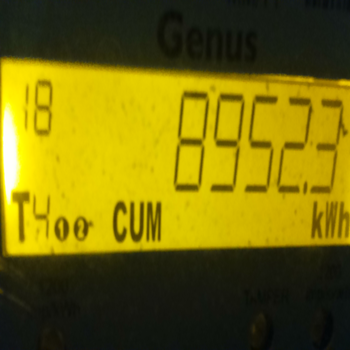

Example 9:
Model Answer : 00839.0
Ground Truth : 00839.0
Match        : True



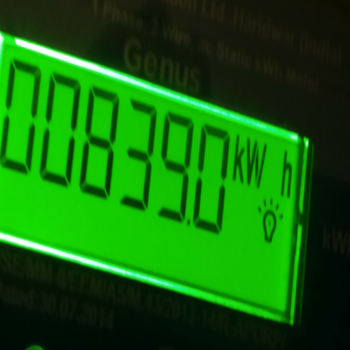

Example 10:
Model Answer : 8733.2
Ground Truth : 8733.2
Match        : True



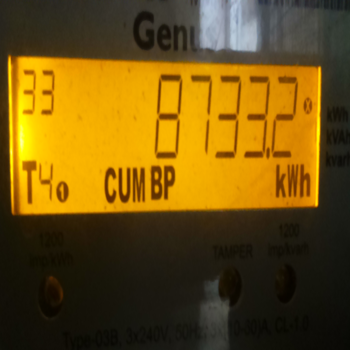

In [10]:
for idx in range(10):
    raw_answer = run_example("DocVQA", 'What is the meter values?', test_data[idx]['image'])
    label = test_data[idx]['label']
    answer_value = list(raw_answer.values())[0]
    is_match = answer_value == label

    print(f'Example {idx + 1}:')
    print(f'Model Answer : {answer_value}')
    print(f'Ground Truth : {label}')
    print(f'Match        : {is_match}\n')

    display(test_data[idx]['image'].resize((350, 350)))

Model Answer : 4563.61


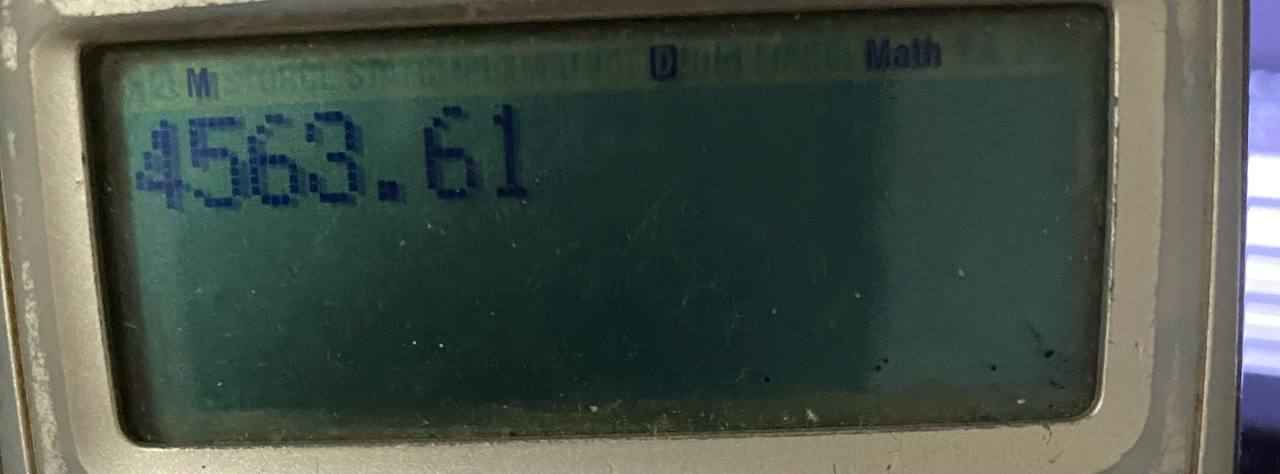

In [11]:
from PIL import Image

test_image_1 = Image.open("../images/test-image-1.jpg")
raw_answer = run_example("DocVQA", 'What is the meter values?', test_image_1)
answer_value = list(raw_answer.values())[0]

print(f'Model Answer : {answer_value}')
display(test_image_1)

Model Answer : 32.467


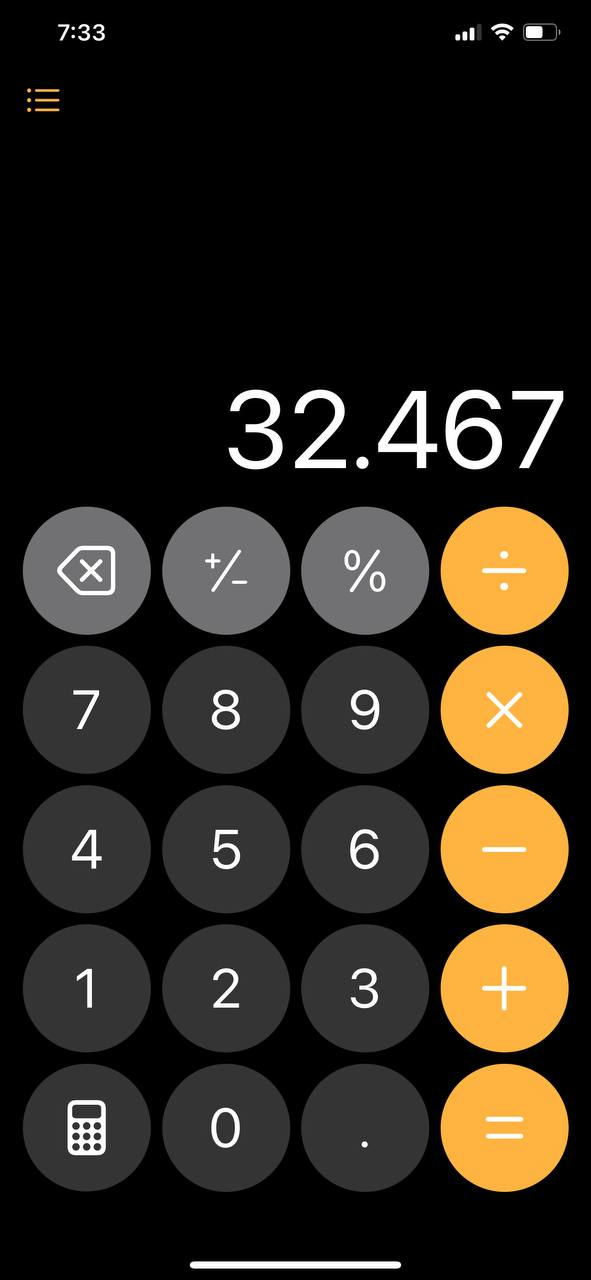

In [12]:
test_image_2 = Image.open("../images/test-image-2.jpg")

raw_answer = run_example("DocVQA", 'What is the meter values?', test_image_2)
answer_value = list(raw_answer.values())[0]

print(f'Model Answer : {answer_value}')
display(test_image_2)

Model Answer : 3.14


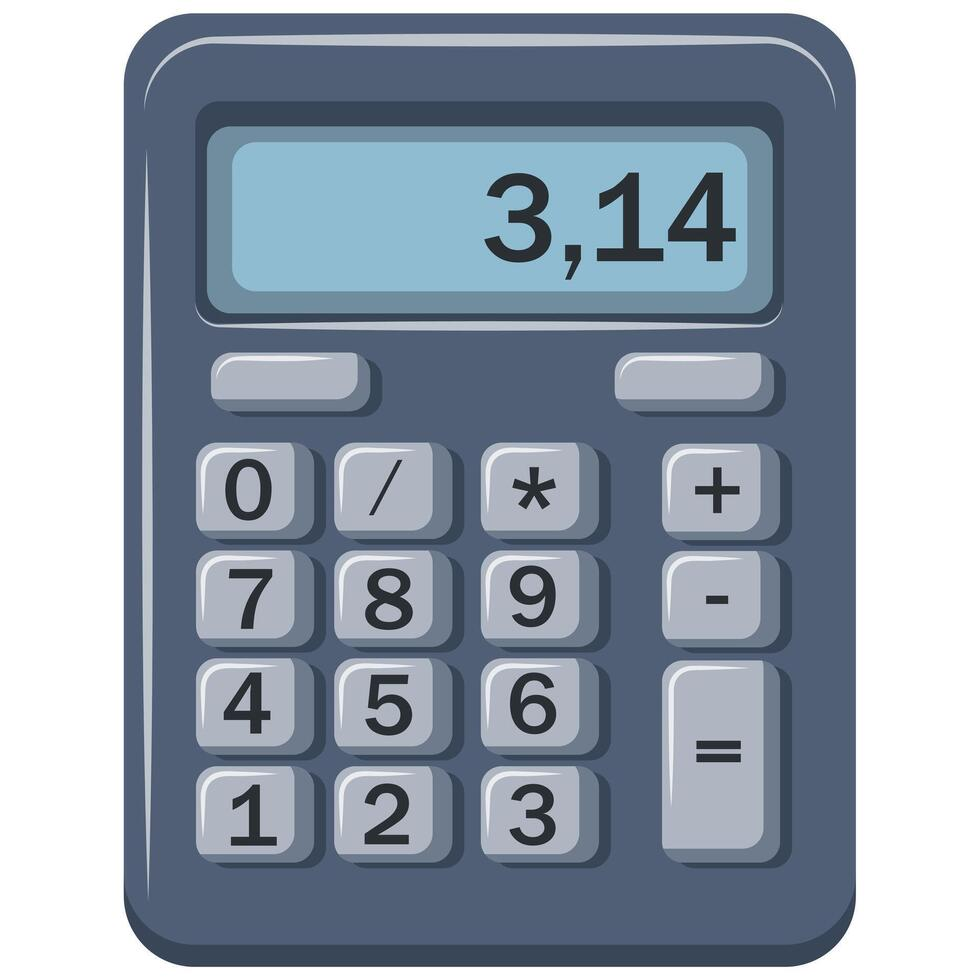

In [13]:
test_image_3 = Image.open("../images/test-image-3.jpg")

raw_answer = run_example("DocVQA", 'What is the meter values?', test_image_3)
answer_value = list(raw_answer.values())[0]

print(f'Model Answer : {answer_value}')
display(test_image_3)